# Sentinel-1 stage-in

### Search parameters

Define the series

In [1]:
series = 'https://catalog.terradue.com/sentinel1/search'

Define the area of interest as a lon,lat point and an extent

In [2]:
lon = -3.611068725585937 
lat = 40.5760213692903
extent = 0.1

Define the time of interest

In [3]:
slave_start_date = '2018-03-12T00:00:00'
slave_stop_date = '2018-03-12T23:59:59'

master_start_date = '2018-02-16T00:00:00'
master_stop_date = '2018-02-16T23:59:59'

### Import the required modules

In [4]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import sys
import glob
os.environ['_CIOP_APPLICATION_PATH']=''
sys.path.append('/opt/anaconda/bin/')
import cioppy
ciop = cioppy.Cioppy()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap

import gc

### Stage-in folder

In [5]:
tmp_dir = '/workspace/data'

In [6]:
if not os.path.isdir(tmp_dir):
    os.makedirs(tmp_dir)

### Build and submit the catalog search

Create a bounding box with the point and the extent

In [7]:
lon_min = lon - extent
lon_max = lon + extent
lat_min = lat - extent
lat_max = lat + extent

Format the bounding box for the catalog search 

In [8]:
bbox = '%s,%s,%s,%s' % (str(lon_min), str(lat_min), str(lon_max), str(lat_max))

Here's the final OpenSearch query

In [24]:
slave_opensearch_params = dict([('bbox', bbox),
                                ('start', slave_start_date),
                                ('stop', slave_stop_date),
                                ('pt', 'GRD'), 
                                ('do', 'terradue')])


master_opensearch_params = dict([('bbox', bbox),
                                 ('start', master_start_date),
                                 ('stop', master_stop_date),
                                 ('pt', 'GRD'),
                                 ('do', 'terradue')])

Submit the query to the catalogue

In [11]:
slave_search = ciop.search(end_point = series,
                     params = slave_opensearch_params,
                     output_fields='enclosure,identifier', 
                     model='GeoTime')

master_search = ciop.search(end_point = series,
                     params = master_opensearch_params,
                     output_fields='enclosure,identifier', 
                     model='GeoTime')

search = slave_search + master_search

In [14]:
for index, elem in enumerate(search):
    print(index, elem['identifier'])

(0, 'S1B_IW_GRDH_1SDV_20180312T181030_20180312T181055_010002_012226_78F9')
(1, 'S1B_IW_GRDH_1SDV_20180312T181005_20180312T181030_010002_012226_91B4')
(2, 'S1A_IW_GRDH_1SDV_20180312T061753_20180312T061818_020978_024034_457D')
(3, 'S1B_IW_GRDH_1SDV_20180216T181030_20180216T181055_009652_01167B_DB9E')
(4, 'S1B_IW_GRDH_1SDV_20180216T181005_20180216T181030_009652_01167B_1678')
(5, 'S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18')


### Stage-in the data

Select the index of the returned results

In [15]:
slave_index = 2
master_index = 5

Stage-in the data or if it's already staged-in only set the *retrieved* variable

In [16]:
for index in [slave_index, master_index]:
    try:
        retrieved = ciop.copy(search[index]['enclosure'], tmp_dir)
    except:
        retrieved = os.path.join(tmp_dir, search[index]['identifier'])

Split into a path and an identifier

In [23]:
data_path = os.path.split(retrieved)[0]
s1_identifier = os.path.split(retrieved)[1]
s1_identifier

'S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18'

In [18]:
data_path

'/workspace/data'

### Create and plot a subset

In [19]:
s1meta = "manifest.safe"
s1prd = os.path.join(data_path, s1_identifier, s1_identifier + '.SAFE', s1meta)

s1prd

'/workspace/data/S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18/S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18.SAFE/manifest.safe'

In [20]:
x = 13727
y = 10438
width = 6186
height = 6942

reader = ProductIO.getProductReader("SENTINEL-1")
product = reader.readProductNodes(s1prd, None)

HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('region', "%s,%s,%s,%s" % (x, y, width, height))
subset = GPF.createProduct('Subset', parameters, product)


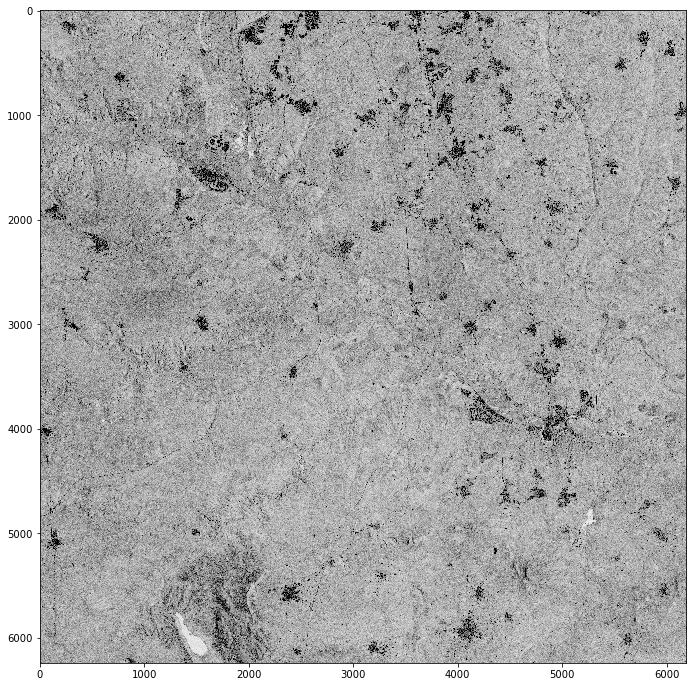

In [21]:
%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    
    return imgplot 

plotBand(subset, 'Amplitude_VV', 0, 350)